In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import explained_variance_score, median_absolute_error, r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone # Clone estimator
from sklearn.metrics import mean_squared_error as MSE
from scipy import stats

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 1. DATA CLEANSING AND ANALYSIS

Let's first read in the house data as a dataframe "house" and inspect the first 5 rows

In [6]:
house = pd.read_csv("newdata2.csv")
house.head()

,Ticker,EV/TTM,TTM Rev Growth,NTM Rev Growth,GP Margin,R&D Margin,S&M Margin,EBITDA Margin
0,SMAR US Equity,22.467831,1.730068,0.760249,0.805111,0.337879,0.655488,-0.403603
1,OKTA US EQUITY,17.244657,2.773790,0.308145,0.704052,0.218452,0.533546,-0.359564
2,MDB US Equity,16.751271,1.945274,0.412487,0.720585,0.323563,0.571938,-0.560198
3,TEAM US Equity,16.244587,1.072875,0.324274,0.812349,0.438849,0.198422,0.045933
4,TENB US Equity,15.777605,0.509411,0.567047,0.863696,0.307217,0.619511,-0.192130


In [7]:
# Dropping the id and date columns
house = house.drop(house.columns[0],axis=1)

In [8]:
house.describe()

,EV/TTM,TTM Rev Growth,NTM Rev Growth,GP Margin,R&D Margin,S&M Margin,EBITDA Margin
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,7.543058,0.528432,0.216193,0.707211,0.200162,0.341511,0.028646
std,3.959135,0.488850,0.182720,0.121692,0.096074,0.161951,0.241920
min,1.256451,0.017831,0.008429,0.310098,0.025551,0.032649,-1.114374
25%,4.589006,0.194930,0.093431,0.640323,0.135206,0.209131,-0.114647
50%,6.752002,0.404623,0.181635,0.714583,0.182750,0.309757,0.042316
75%,9.676390,0.656987,0.287955,0.797478,0.246220,0.446033,0.195914
max,22.467831,2.773790,1.279817,0.949200,0.627796,0.726084,0.500626


**Pairplot Visualisation**

Let's create some Seaborn pairplots for the features ('sqft_lot','sqft_above','price','sqft_living','bedrooms') to get a feel for how the various features are distributed vis-a-vis the price as well as the number of bedrooms

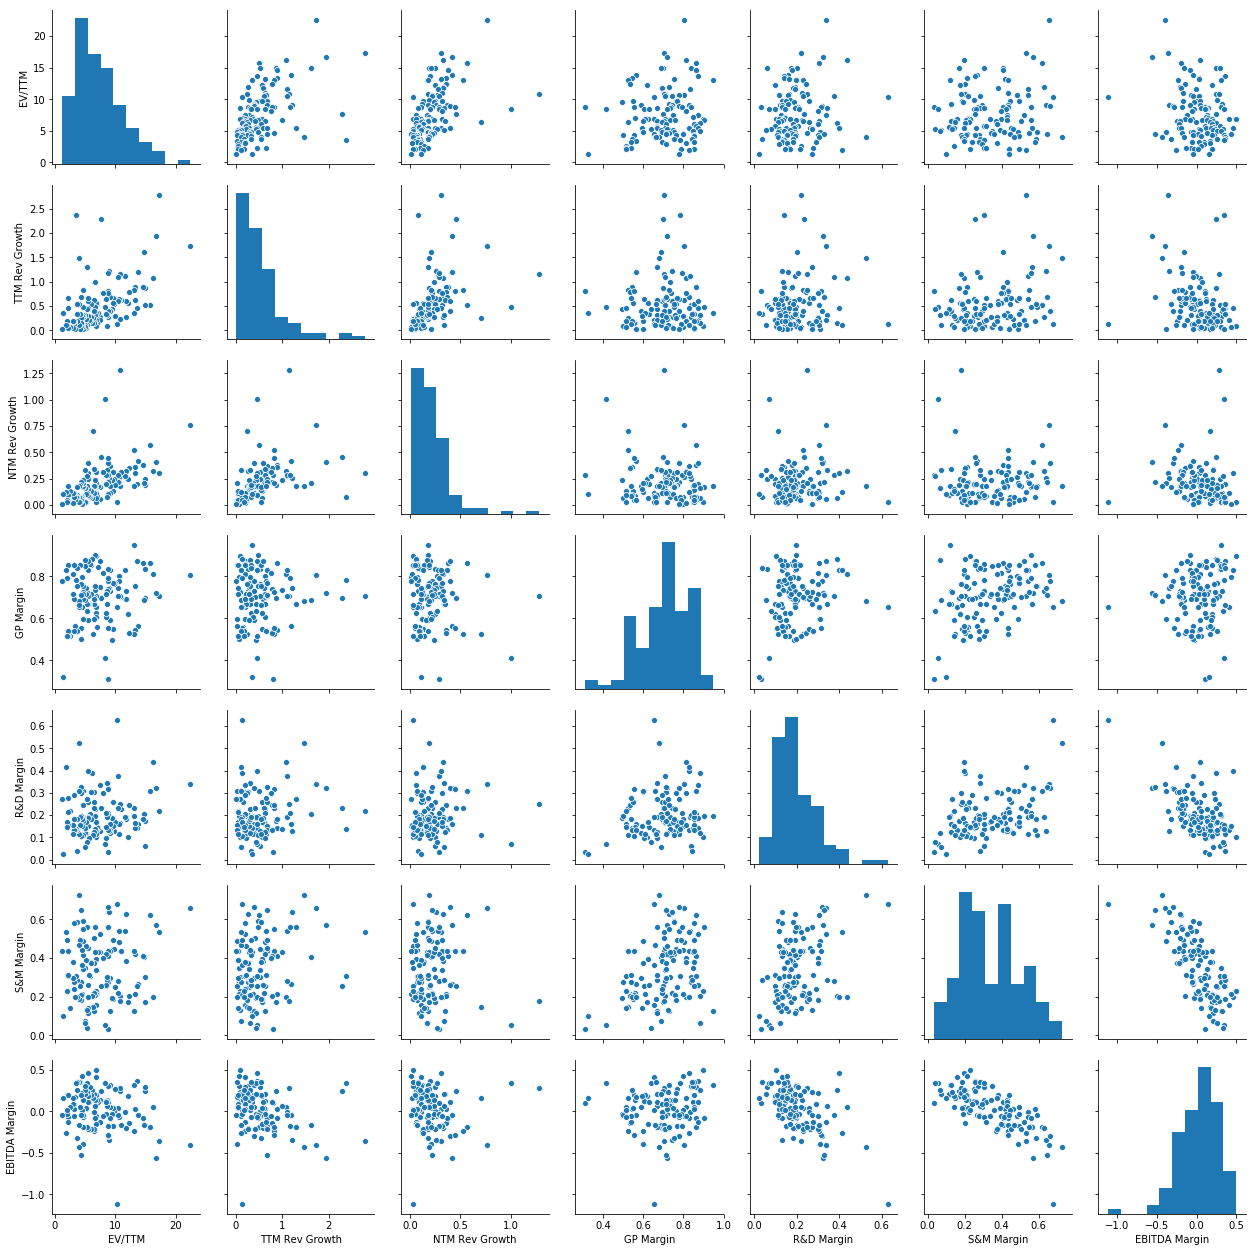

In [9]:
#sns.pairplot(house[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], hue='bedrooms', palette='afmhot',size=1.4)
sns_plot = sns.pairplot(house)
sns_plot.savefig("output.png")

From the pairplots, we seem to get the classical linear distribution of the data points, for example with price against sqft_living. This bodes well as in the latter analysis, we will implement some linear models which we will use in our Feature ranking. Let's look at the correlation heatmap: 

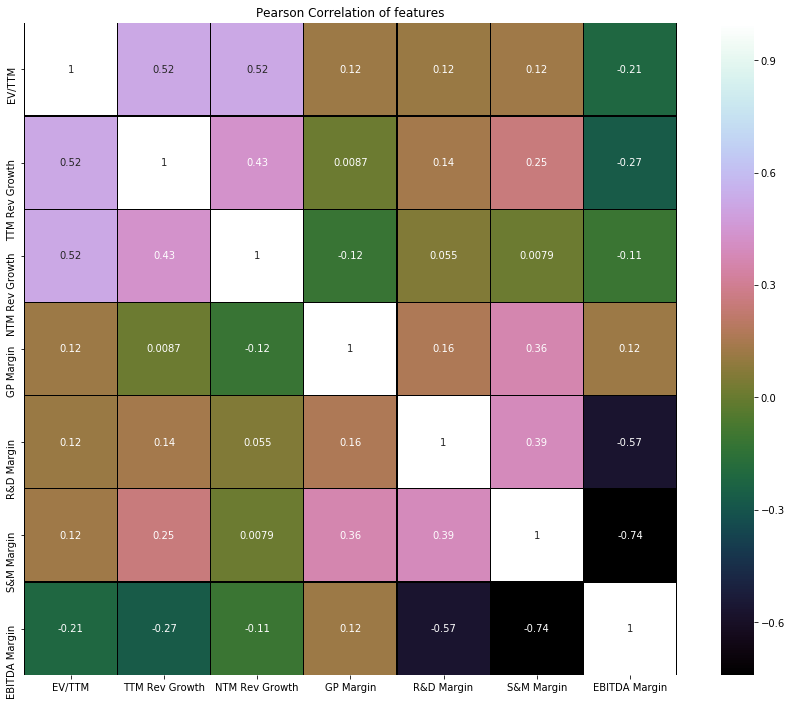

In [10]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in house.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = house.columns.difference(str_list) 
# Create Dataframe containing only numerical features
house_num = house[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns_heat = sns.heatmap(house.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)
figure = sns_heat.get_figure()    
figure.savefig('heat.png')

# 2. Stability Selection via Randomized Lasso

In a nutshell, this method serves to apply the feature selection on different parts of the data and features repeatedly until the results can be aggregated. Therefore stronger features ( defined as being selected as important) will have greater scores in this method as compared to weaker features. Refer to this paper by Nicolai Meinshausen and Peter Buhlmann for a much greater detail on the method : http://stat.ethz.ch/~nicolai/stability.pdf

In this notebook, the Stability Selection method is conveniently inbuilt into sklearn's randomized lasso model and therefore this will be implemented as follows:

In [11]:
# First extract the target variable which is our House prices
Y = house['EV/TTM']
Y = Y.values.ravel()
# Drop price from the house dataframe and create a matrix out of the house data
house = house.drop(['EV/TTM'], axis=1)
X = house.as_matrix()
# Store the column/feature names into a list "colnames"
colnames = house.columns

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [12]:
colnames

Index(['TTM Rev Growth', 'NTM Rev Growth', 'GP Margin', 'R&D Margin',
       'S&M Margin', 'EBITDA Margin'],
      dtype='object')

Next, we create a function which will be able to conveniently store our feature rankings obtained from the various methods described here into a Python dictionary. In case you are thinking I created this function, no this is not the case. All credit goes to Ando Saabas and I am only trying to apply what he has discussed in the context of this dataset.

In [13]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [14]:
# Finally let's run our Selection Stability method with Randomized Lasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
print('finished')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


finished


# 3. Recursive Feature Elimination ( RFE )

Now onto the next method in our feature ranking endeavour. Recursive Feature Elimination or RFE uses a model ( eg. linear Regression or SVM) to select either the best or worst-performing feature, and then excludes this feature. The whole process is then iterated until all features in the dataset are used up ( or up to a user-defined limit). Sklearn conveniently possesses a RFE function via the sklearn.feature_selection call and we will use this along with a simple linear regression model for our ranking search as follows:

In [15]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


# 4. Linear Model Feature Ranking

Now let's apply 3 different linear models (Linear, Lasso and Ridge Regression) and how the features are selected and prioritised via these models. To achieve this, I shall use the sklearn implementation of these models and in particular the attribute .coef to return the estimated coefficients for each feature in the linear model.

In [16]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

# 5. Random Forest feature ranking

Sklearn's Random Forest model also comes with it's own inbuilt feature ranking attribute and one can conveniently just call it via "feature_importances_". That is what we will be using as follows:

In [17]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

building tree 1 of 50building tree 2 of 50building tree 3 of 50
building tree 4 of 50


building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50building tree 10 of 50building tree 11 of 50

building tree 12 of 50

building tree 13 of 50
building tree 14 of 50
building tree 15 of 50building tree 16 of 50

building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50building tree 22 of 50

building tree 23 of 50building tree 24 of 50

building tree 25 of 50
building tree 26 of 50building tree 27 of 50

building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50building tree 38 of 50

building tree 39 of 50building tree 40 of 50

building tree 41 of 50
building tree 42 of 50
building tree 43 of 50building tree 44 of 5

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.0s finished


# 6. Creating the Feature Ranking Matrix

We combine the scores from the various methods above and output it in a matrix form for convenient viewing as such:

In [18]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Lasso	LinReg	RF	RFE	Ridge	rlasso/Stability	Mean
TTM Rev Growth	0.44	0.0	0.33	0.0	1.0	0.97	0.46
NTM Rev Growth	1.0	0.47	1.0	1.0	0.98	1.0	0.91
GP Margin	0.24	1.0	0.15	0.8	0.27	0.42	0.48
R&D Margin	0.0	0.35	0.0	0.2	0.0	0.03	0.1
S&M Margin	0.0	0.82	0.03	0.6	0.0	0.0	0.24
EBITDA Margin	0.09	0.6	0.12	0.4	0.26	0.27	0.29


Now, with the matrix above, the numbers and layout does not seem very easy or pleasant to the eye. Therefore, let's just collate the mean ranking score attributed to each of the feature and plot that via Seaborn's factorplot.

In [19]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


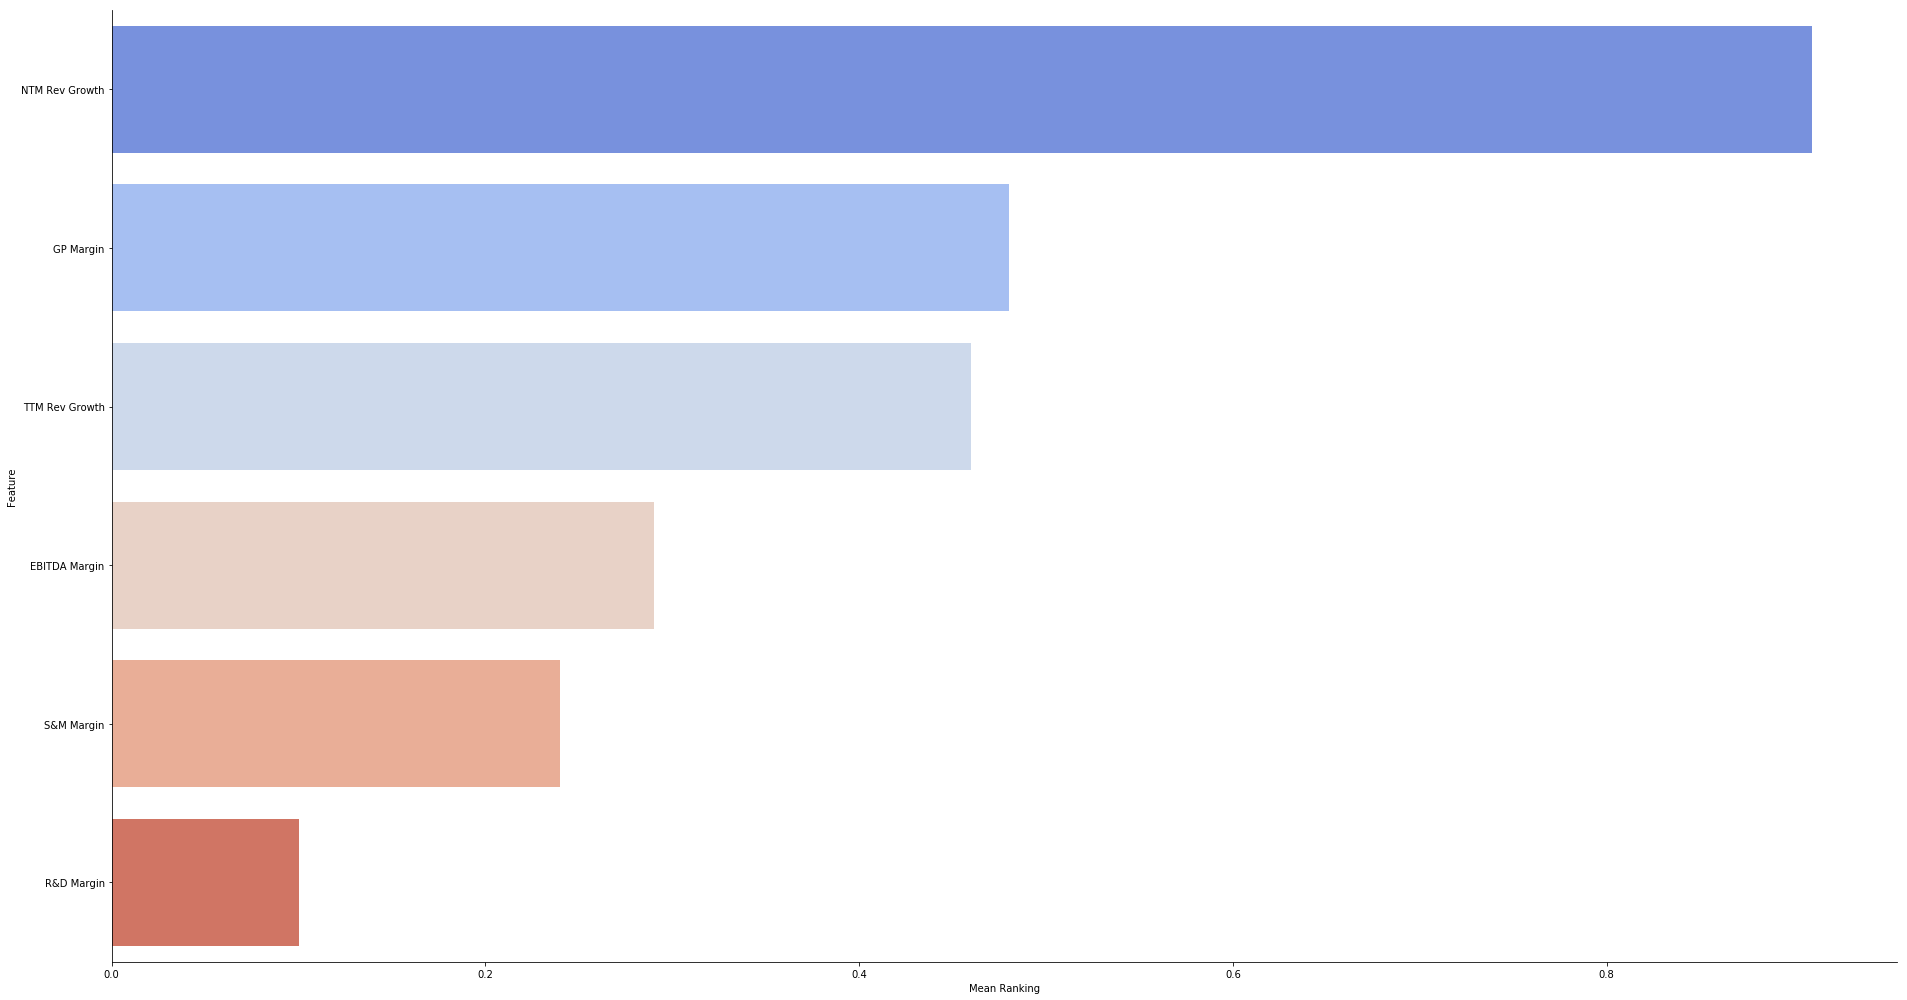

In [20]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')

In [21]:
house = house.drop(['R&D Margin'], axis=1)

In [22]:
#house = house.drop(['TTM Rev Growth'], axis=1)

In [23]:
house.head()

,TTM Rev Growth,NTM Rev Growth,GP Margin,S&M Margin,EBITDA Margin
0,1.730068,0.760249,0.805111,0.655488,-0.403603
1,2.773790,0.308145,0.704052,0.533546,-0.359564
2,1.945274,0.412487,0.720585,0.571938,-0.560198
3,1.072875,0.324274,0.812349,0.198422,0.045933
4,0.509411,0.567047,0.863696,0.619511,-0.192130


In [24]:
# Store the column/feature names into a list "colnames"
colnames = house.columns
X = house.as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state=3)

In [26]:
thresh = 1 * 10**(-3)
model = XGBRegressor()
model.fit(X_train, y_train)
#select features using threshold
selection = SelectFromModel(model, threshold = thresh, prefit=True)
select_X_train = selection.transform(X_train)
# eval model
select_X_val = selection.transform(X_test)
# test 
select_X_test = selection.transform(X_test)
print(select_X_train.shape)
print(select_X_val.shape)
print(select_X_test.shape)

(97, 5)
(25, 5)
(25, 5)


Scaled_Ridge: 0.285614 (+/- 0.165642)
Scaled_Lasso: 0.166195 (+/- 0.088746)
Scaled_Elastic: 0.190701 (+/- 0.086362)
Scaled_SVR: 0.085139 (+/- 0.351227)
Scaled_RF_reg: 0.178680 (+/- 0.195486)
Scaled_ET_reg: 0.277651 (+/- 0.103929)
Scaled_BR_reg: 0.150738 (+/- 0.154161)
Scaled_Hub-Reg: 0.226101 (+/- 0.218514)
Scaled_BayRidge: 0.286222 (+/- 0.155862)
Scaled_XGB_reg: 0.114900 (+/- 0.311356)
Scaled_KNN_reg: 0.265923 (+/- 0.171828)
Scaled_ADA-Reg: 0.215828 (+/- 0.119779)
Scaled_Linear: 0.282123 (+/- 0.169904)
Scaled_Gboost-Reg: 0.118516 (+/- 0.306224)
Scaled_RFR_PCA: 0.188005 (+/- 0.312346)
Scaled_XGBR_PCA: 0.083231 (+/- 0.494417)


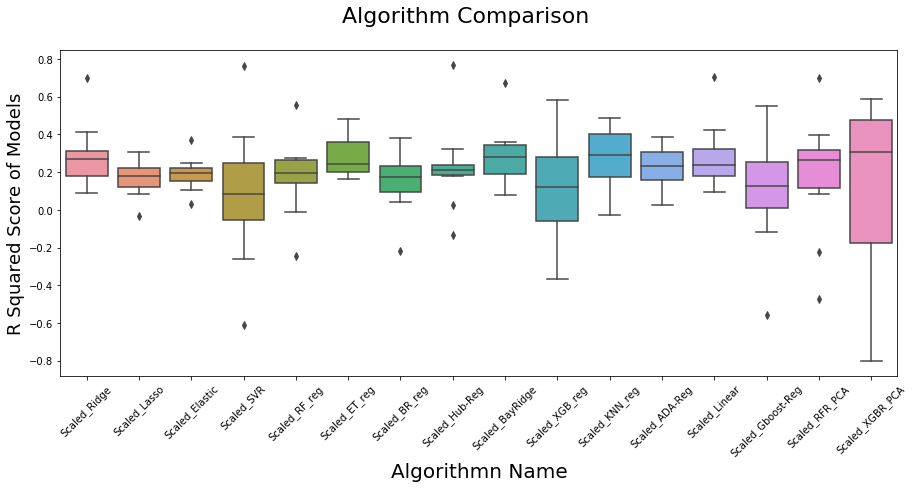

In [27]:
pipelines = []
seed = 2

pipelines.append(
                ("Scaled_Ridge", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Ridge", Ridge(random_state=seed, tol=10 ))
                      ]))
                )
pipelines.append(
                ("Scaled_Lasso", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", Lasso(random_state=seed, tol=1))
                      ]))
                )
pipelines.append(
                ("Scaled_Elastic", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", ElasticNet(random_state=seed))
                      ]))
                )

pipelines.append(
                ("Scaled_SVR",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("SVR",  SVR(kernel='linear', C=1e2, degree=5))
                 ])
                )
                )

pipelines.append(
                ("Scaled_RF_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("RF", RandomForestRegressor(random_state=seed))
                 ])
                )
                )

pipelines.append(
                ("Scaled_ET_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ET", ExtraTreesRegressor(random_state=seed))
                 ])
                )
                )
pipelines.append(
                ("Scaled_BR_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BaggingRegressor(random_state=seed))
                 ]))) 

pipelines.append(
                ("Scaled_Hub-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Hub-Reg", HuberRegressor())
                 ]))) 
pipelines.append(
                ("Scaled_BayRidge",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BayesianRidge())
                 ]))) 

pipelines.append(
                ("Scaled_XGB_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("XGBR", XGBRegressor(seed=seed))
                 ]))) 

pipelines.append(
                ("Scaled_KNN_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("KNN_reg", KNeighborsRegressor())
                 ])))
pipelines.append(
                ("Scaled_ADA-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ADA-reg", AdaBoostRegressor())
                 ]))) 

pipelines.append(
                ("Scaled_Linear",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Linear", LinearRegression())
                 ]))) 

pipelines.append(
                ("Scaled_Gboost-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("GBoost-Reg", GradientBoostingRegressor())
                 ])))

pipelines.append(
                ("Scaled_RFR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", RandomForestRegressor())
                 ])))

pipelines.append(
                ("Scaled_XGBR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", XGBRegressor())
                 ])))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'r2'
n_folds = 10

results, names  = [], [] 

for name, model  in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn Name", fontsize=20)
ax.set_ylabel("R Squared Score of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

Scaled_Ridge: 0.285614 (+/- 0.165642)
Scaled_ET_reg: 0.277651 (+/- 0.103929)
Scaled_BayRidge: 0.286222 (+/- 0.155862)
Scaled_Linear: 0.282123 (+/- 0.169904)


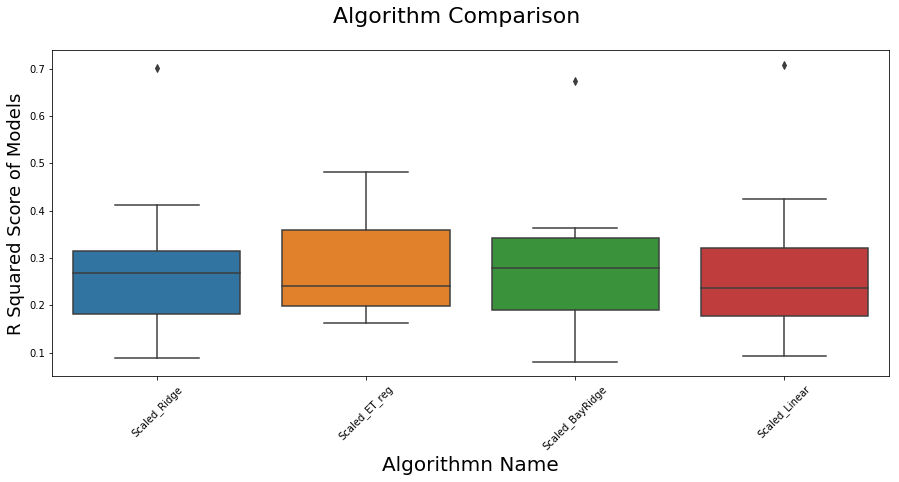

In [28]:
pipelines = []
seed = 2

pipelines.append(
                ("Scaled_Ridge", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Ridge", Ridge(random_state=seed, tol=10 ))
                      ]))
                )


pipelines.append(
                ("Scaled_ET_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ET", ExtraTreesRegressor(random_state=seed))
                 ])
                )
                )

pipelines.append(
                ("Scaled_BayRidge",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BayesianRidge())
                 ]))) 


pipelines.append(
                ("Scaled_Linear",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Linear", LinearRegression())
                 ]))) 

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'r2'
n_folds = 10

results, names  = [], [] 

for name, model  in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x=names, y=results)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn Name", fontsize=20)
ax.set_ylabel("R Squared Score of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [29]:
pipelines[-4][1]

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=10))])

In [30]:
Ridge = pipelines[-4][1]

param_grid_rf =  [ { 
       }]

grid_rf = GridSearchCV(estimator=Ridge,
                               param_grid= param_grid_rf,
                               scoring= 'neg_mean_squared_error',
                               cv = KFold(n_splits= 3, random_state= seed, shuffle=True),
                               verbose = 1 )
# Fit grid
grid_rf.fit(select_X_train, y_train)

# Best score and best parameters
print('-------Best score----------')
print(grid_rf.best_score_ )
print('-------Best params----------')
print(grid_rf.best_params_)          

Fitting 3 folds for each of 1 candidates, totalling 3 fits
-------Best score----------
-9.58506891363229
-------Best params----------
{}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


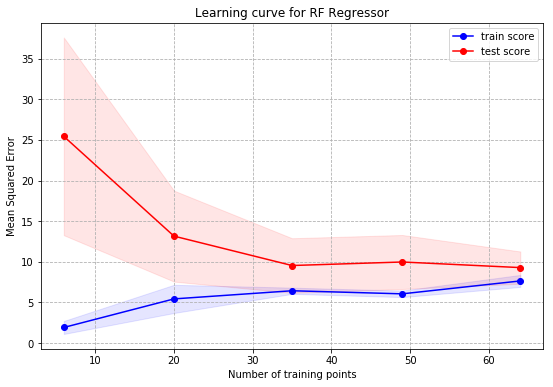

In [31]:
def plot_learning_curve(train_sizes, train_scores, test_scores, title, alpha=0.1):
    train_scores = -train_scores
    test_scores = -test_scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(train_sizes,train_mean + train_std,
                    train_mean - train_std, color='blue', alpha=alpha)
    plt.plot(train_sizes, test_mean, label='test score', color='red',marker='o')
    plt.fill_between(train_sizes,test_mean + test_std, test_mean - test_std , color='red', alpha=alpha)
    plt.title(title)
    plt.xlabel('Number of training points')
    plt.ylabel(r'Mean Squared Error')
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show() 
    
# Plot the learning curve
plt.figure(figsize=(9,6))
train_sizes, train_scores, test_scores = learning_curve(
                                            grid_rf.best_estimator_ , X= select_X_train, y = y_train, 
                                            cv= 3,  scoring='neg_mean_squared_error')

plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for RF Regressor') 

In [32]:
best_model = clone(grid_rf.best_estimator_)
best_model.fit(select_X_train, y_train)
y_pred_train = best_model.predict(select_X_train)

print( "Training Root Mean Squared Error %.2f" %( MSE(y_train, y_pred_train)**(1/2) ) )

Training Root Mean Squared Error 2.85


In [33]:
y_pred_val = best_model.predict(select_X_val)
print("Root Mean Squared Error on Holdout Set %f" %(MSE(y_test, y_pred_val)**(1/2)))

Root Mean Squared Error on Holdout Set 3.185516


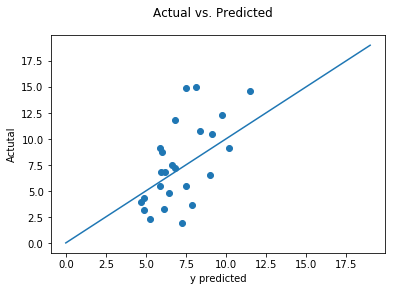

In [47]:
x15= range(20)
plt.plot(x15,x15)
plt.scatter(y_pred_val, y_test)
plt.suptitle("Actual vs. Predicted")
plt.xlabel("y predicted")
plt.ylabel("Actutal")
plt.show()

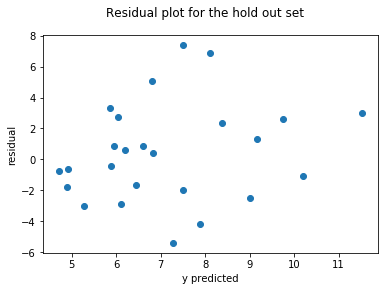

In [35]:
plt.scatter(y_pred_val, y_test - y_pred_val)
plt.suptitle("Residual plot for the hold out set")
plt.xlabel("y predicted")
plt.ylabel("residual")
plt.show()

In [45]:
resid = y_test - y_pred_val
resid

array([ 2.73903648, -0.73920166,  6.8969669 , -1.08018518, -2.01066681,
        1.3406404 ,  3.02756764, -0.40506415,  5.05363792,  7.37442828,
        2.35772699, -1.77566647,  0.89271325, -4.20421105,  2.58271015,
       -0.62483551,  3.30469742,  0.38182736, -5.39209174, -2.51387544,
        0.6091755 , -1.65370219,  0.86270142, -2.86936091, -3.00383211])

In [37]:
#databricks = [1.24719232418189,0.951862931344295,0.671300585943595,0.577080777881529,0.981899434820076,-1.14895360823323]
databricks = [1.24719232418189,0.951862931344295,0.671300585943595,0.981899434820076,-1.14895360823323]

db = pd.DataFrame([databricks])
db = db.as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [38]:
best_model

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=2, solver='auto', tol=10))])

In [39]:
db

array([[ 1.24719232,  0.95186293,  0.67130059,  0.98189943, -1.14895361]])

In [40]:
db_pred = best_model.predict(db)

In [41]:
actualdb = db_pred
actualdb

array([16.89132686])

In [46]:
house.head()

,TTM Rev Growth,NTM Rev Growth,GP Margin,S&M Margin,EBITDA Margin
0,1.730068,0.760249,0.805111,0.655488,-0.403603
1,2.773790,0.308145,0.704052,0.533546,-0.359564
2,1.945274,0.412487,0.720585,0.571938,-0.560198
3,1.072875,0.324274,0.812349,0.198422,0.045933
4,0.509411,0.567047,0.863696,0.619511,-0.192130


In [43]:
yhat = best_model.predict(select_X_val).flatten()
SS_Residual1 = sum((y_test-yhat)**2)
std_err1 = math.sqrt(SS_Residual1/122)
moe_1 = std_err1 * 1.1 * t
print (std_err1,moe_1)

regression_model_mse = mean_squared_error(yhat, y_test)
print (math.sqrt(regression_model_mse))

SS_Total = sum((y_test-np.mean(y_test))**2)
r_squared = 1 - (float(SS_Residual1))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print (r_squared,adjusted_r_squared)

NameError: name 'math' is not defined

In [ ]:
yhat

In [ ]:
y_test

In [ ]:
y_val = y_test

In [ ]:
import math

In [ ]:
t = 1.98062600245909 #consistent with sample size at 95% confidence interval